In [89]:
from yellowbrick.target import FeatureCorrelation
import h5py
from GNN.inputs import split
from GNN.utils.cm import plot_confusion_matrix
import matplotlib.pyplot as plt 
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import mean_squared_error, confusion_matrix, precision_recall_fscore_support
from yellowbrick.features import Rank2D
from sklearn.decomposition import PCA
from halotools.mock_observables import tpcf
import pickle

# Read inputs

In [2]:
hdf5_filename = "/cosma5/data/dp004/dc-cues1/features/halo_features_s99"
with h5py.File(hdf5_filename, "r+") as feats:

    
    features = np.column_stack(
        [
            feats["M200c"][:],
            feats["R200c"][:],
            feats["N_subhalos"][:],
            feats["VelDisp"][:],
            feats["Vmax"][:],
            feats["Spin"][:],
            feats["Fsub"][:],
            feats["x_offset"][:],

        ]
    )   
    
    
    positions = feats['Pos'][:] / 1000.
    boxsize = feats['boxsize'].value / 1000. # to Mpc


    #labels = np.log10(feats["stellar_mass"][:] + 1 )
    labels = feats['Ngals'][:]
    labels = labels > 0 



In [3]:
feature_names = ['M200c', 'R200c', 'N_subhalos', 'VelDisp', 'Vmax', 'Spin', 'Fsub', 'x_offset']

In [5]:
train_idx, test_idx, val_idx = split.train_test_val_split(labels.shape[0],
                                        train_size = 0.5)

test_idx = np.concatenate((test_idx, val_idx))
train_features = features[train_idx, :]
train_labels = labels[train_idx]
test_features = features[test_idx, :]
test_labels = labels[test_idx]




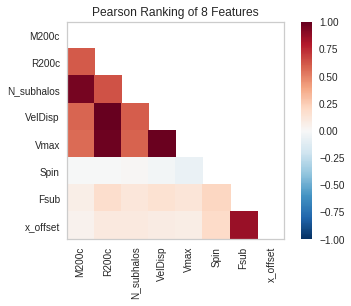

In [7]:
visualizer = Rank2D(features=feature_names, algorithm='pearson')

visualizer.fit(features, labels)
visualizer.transform(features)  
visualizer.poof()  

# Standarize features

In [8]:

scaler = StandardScaler()

scaler.fit(train_features)

train_features = scaler.transform(train_features)
test_features = scaler.transform(test_features)


Text(0,0.5,'cumulative explained variance')

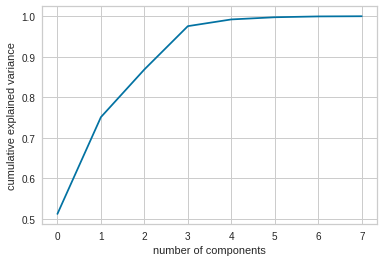

In [9]:
pca = PCA().fit(train_features)

plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance')

In [10]:
n_components = 5
pca = PCA(n_components = n_components)
pca.fit(train_features)

pca_train = pca.transform(train_features)

pca_test = pca.transform(test_features)
#pca_test_reconstruction = pca.inverse_transform(pca_test)

In [11]:
pca_names = [f'pca-{i}' for i in range(n_components)]

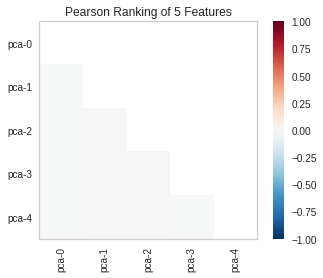

In [12]:
visualizer = Rank2D(features=pca_names, algorithm='pearson')

visualizer.fit(pca_train, labels)
visualizer.transform(pca_train)  
visualizer.poof()  

# Random Forest on Features

In [65]:
n_estimators = 400

rf = RandomForestClassifier(n_estimators= n_estimators)

rf.fit(train_features, train_labels)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=400,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

Normalized confusion matrix


(array([[0.93453493, 0.06546507],
        [0.05764059, 0.94235941]]),
 <matplotlib.axes._subplots.AxesSubplot at 0x2b42d9a25b38>)

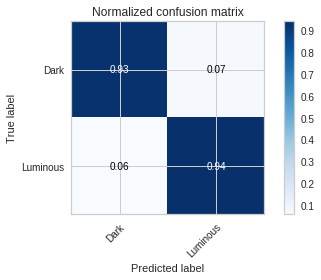

In [66]:
test_pred = rf.predict(test_features)
plot_confusion_matrix(test_labels, test_pred, 
    classes = ['Dark', 'Luminous'], normalize = True)

In [67]:
importances = rf.feature_importances_
std = np.std([tree.feature_importances_ for tree in rf.estimators_],
                     axis=0)
indices = np.argsort(importances)[::-1]


In [68]:
feature_names = np.array(feature_names)

(-1, 8)

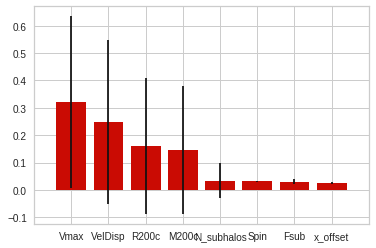

In [69]:
plt.bar(range(train_features.shape[1]), importances[indices],
               color="r", yerr=std[indices], align="center")
plt.xticks(range(train_features.shape[1]), feature_names[indices])
plt.xlim([-1, train_features.shape[1]])


## Compare correlation functions

In [74]:
pos_test = positions[test_idx, :]

pos_test_galaxies = pos_test[test_labels]

r = np.geomspace(0.3, 10., 20)
r_c = 0.5 * (r[1:] + r[:-1])


test_tpcf = tpcf(pos_test_galaxies, rbins = r,
    period = boxsize, estimator =  'Landy-Szalay' )

In [75]:
pos_test_pred = positions[test_idx][test_pred]


predicted_tpcf = tpcf(pos_test_pred, rbins = r, 
    period = boxsize, estimator =  'Landy-Szalay' )

In [85]:
with open('hod_tpcf.pkl', 'rb') as f:
    hod_tpcf = pickle.load(f)

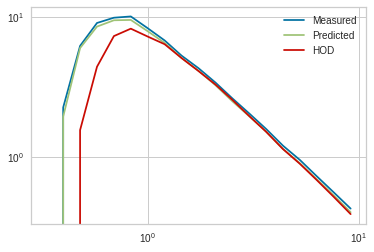

In [87]:
plt.loglog(r_c, test_tpcf, label = 'Measured')
plt.loglog(r_c, predicted_tpcf, label = 'Predicted')
plt.loglog(hod_tpcf['r_c'],
           hod_tpcf['tpcf'], label = 'HOD')

plt.legend()

(0.8, 1.2)

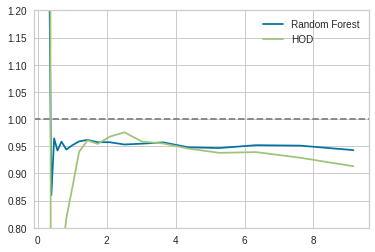

In [88]:
plt.plot(r_c, predicted_tpcf/test_tpcf, label = 'Random Forest')
plt.plot(r_c, hod_tpcf['tpcf']/test_tpcf, label = 'HOD', )

plt.axhline(y = 1., color='gray', linestyle='dashed')
plt.legend()
plt.ylim(0.8,1.2)

In [54]:
# With mass cut:
test_masses = scaler.inverse_transform(test_features)[:,0]

m_min = 5.e11

threshold = test_masses > m_min

pos_test_mass = pos_test[threshold][test_labels[threshold]]

test_tpcf_mass = tpcf(pos_test_mass, rbins = r,
    period = boxsize, estimator =  'Landy-Szalay' )

In [55]:
pos_test_pred_mass = positions[test_idx][threshold][test_pred[threshold]]


predicted_tpcf_mass = tpcf(pos_test_pred_mass, rbins = r, 
    period = boxsize, estimator =  'Landy-Szalay' )

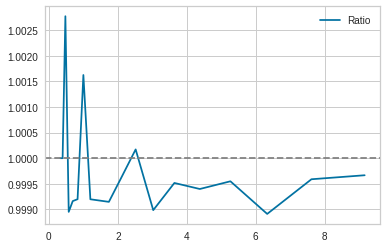

In [56]:
plt.plot(r_c, predicted_tpcf_mass/test_tpcf_mass, label = 'Ratio')
plt.axhline(y = 1., color='gray', linestyle='dashed')
plt.legend()

# Random Forest on PCAs

In [90]:
n_estimators = 200

rf_pca = RandomForestClassifier(n_estimators= n_estimators)

rf_pca.fit(pca_train, train_labels)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=200,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

Normalized confusion matrix


(array([[0.92451127, 0.07548873],
        [0.067856  , 0.932144  ]]),
 <matplotlib.axes._subplots.AxesSubplot at 0x2b42da0bbbe0>)

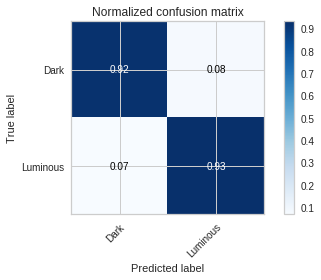

In [91]:
test_pred = rf_pca.predict(pca_test)
plot_confusion_matrix(test_labels, test_pred, 
    classes = ['Dark', 'Luminous'], normalize = True)

In [92]:
importances = rf_pca.feature_importances_
std = np.std([tree.feature_importances_ for tree in rf_pca.estimators_],
                     axis=0)
indices = np.argsort(importances)[::-1]


In [93]:
pca_names = np.array(pca_names)

(-1, 8)

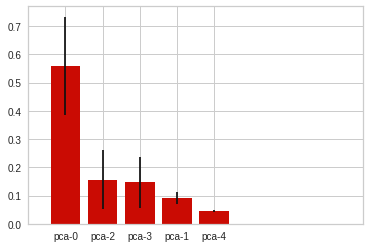

In [94]:
plt.bar(range(pca_train.shape[1]), importances[indices],
               color="r", yerr=std[indices], align="center")

plt.xticks(range(pca_train.shape[1]), pca_names[indices])
plt.xlim([-1, train_features.shape[1]])


In [95]:
pos_test_pred = positions[test_idx][test_pred]


predicted_tpcf = tpcf(pos_test_pred, rbins = r, 
    period = boxsize, estimator =  'Landy-Szalay' )

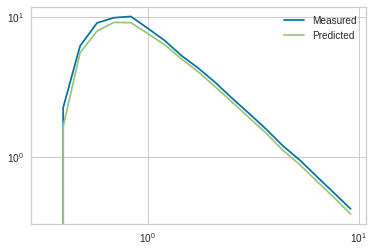

In [96]:
plt.loglog(r_c, test_tpcf, label = 'Measured')
plt.loglog(r_c, predicted_tpcf, label = 'Predicted')
plt.legend()

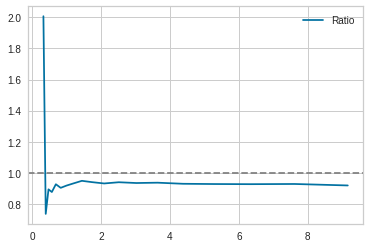

In [97]:
plt.plot(r_c, predicted_tpcf/test_tpcf, label = 'Ratio')
plt.axhline(y = 1., color='gray', linestyle='dashed')
plt.legend()

(0.8, 1.2)

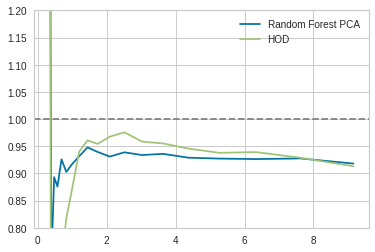

In [98]:
plt.plot(r_c, predicted_tpcf/test_tpcf, label = 'Random Forest PCA')
plt.plot(r_c, hod_tpcf['tpcf']/test_tpcf, label = 'HOD', )

plt.axhline(y = 1., color='gray', linestyle='dashed')
plt.legend()
plt.ylim(0.8,1.2)